In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures, SplineTransformer, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge, SGDRegressor
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict

from sklearn.feature_selection import SelectKBest, RFECV, SelectFromModel
from sklearn.feature_selection import f_classif, f_regression
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

In [5]:
train_df = pd.read_csv('/content/customer_dataset.csv')

In [6]:
train_df

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6
...,...,...,...,...,...,...,...,...,...,...
8063,464018,Male,No,22,No,NaN,0.0,Low,7.0,Cat_1
8064,464685,Male,No,35,No,Executive,3.0,Low,4.0,Cat_4
8065,465406,Female,No,33,Yes,Healthcare,1.0,Low,1.0,Cat_6
8066,467299,Female,No,27,Yes,Healthcare,1.0,Low,4.0,Cat_6


In [7]:
train_df['Age_Group'] = pd.cut(train_df['Age'].values, [-np.inf, 35, 60, np.inf]).codes.astype('str')

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Age_Group        8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


In [63]:
train_df.isna().sum(axis=0)

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Age_Group            0
dtype: int64

In [9]:
train_df.nunique()

ID                 8068
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
Var_1                 7
Age_Group             3
dtype: int64

In [10]:
cat_cols = [
    'Gender',
    'Ever_Married',
    'Graduated',
    'Profession',
    'Spending_Score',
    'Var_1',
    'Age_Group'
]
num_cols = [x for x in train_df.select_dtypes(include=np.number).columns if x not in (cat_cols + ['ID'])]

In [48]:
cat_steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
]
num_steps = [
    ('scaler1', StandardScaler()),
]

cat_transformer = Pipeline(cat_steps)
num_transformer = Pipeline(num_steps)
preprocessor1 = ColumnTransformer(
    [
        ('num',  num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)
preprocessor = Pipeline([
    ('preprocessor1', preprocessor1),
    ('KNNImputer', KNNImputer())
])

In [49]:
X = preprocessor.fit_transform(train_df.drop('ID', axis=1))

In [14]:
X.shape

(8068, 35)

In [50]:
data2d = TSNE(learning_rate='auto', init='random', n_jobs=-1).fit_transform(X)

<Axes: >

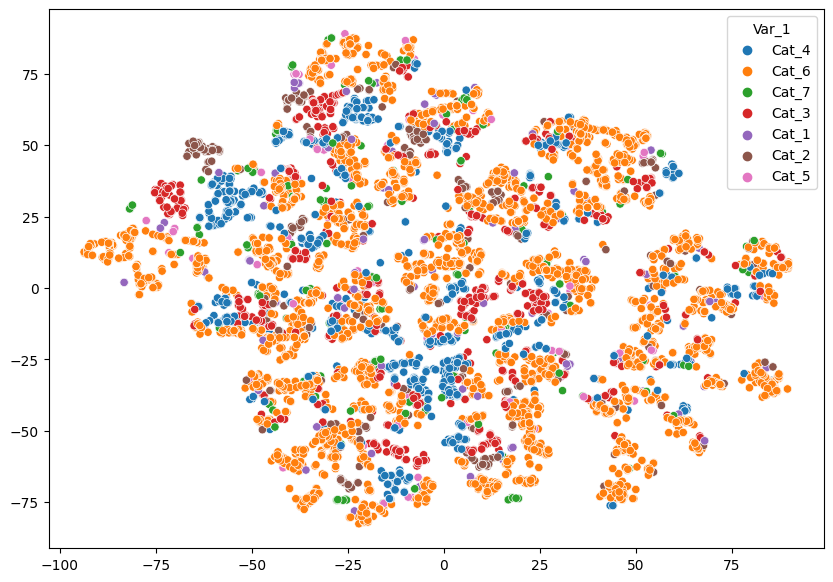

In [51]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data2d[:, 0], y = data2d[:, 1], hue=train_df['Var_1'])

<Axes: >

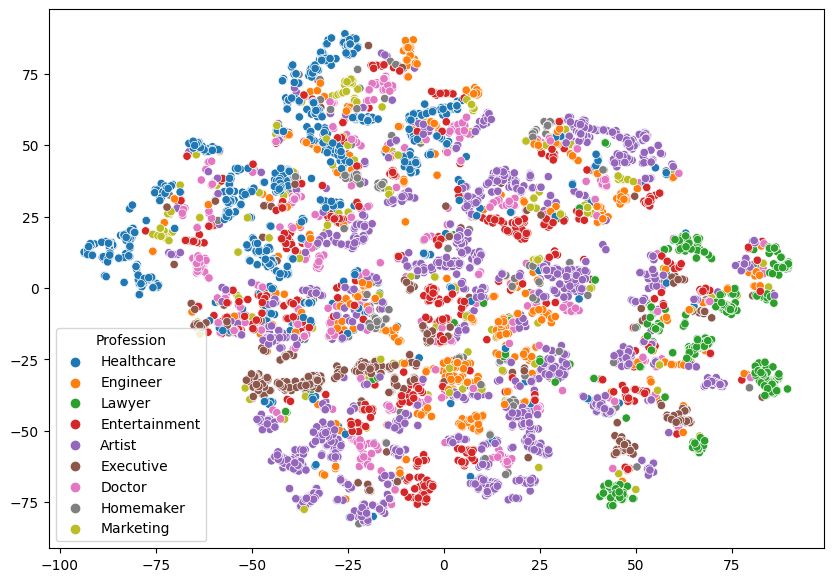

In [52]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data2d[:, 0], y = data2d[:, 1], hue=train_df['Profession'])

/usr/local/lib/python3.9/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: >

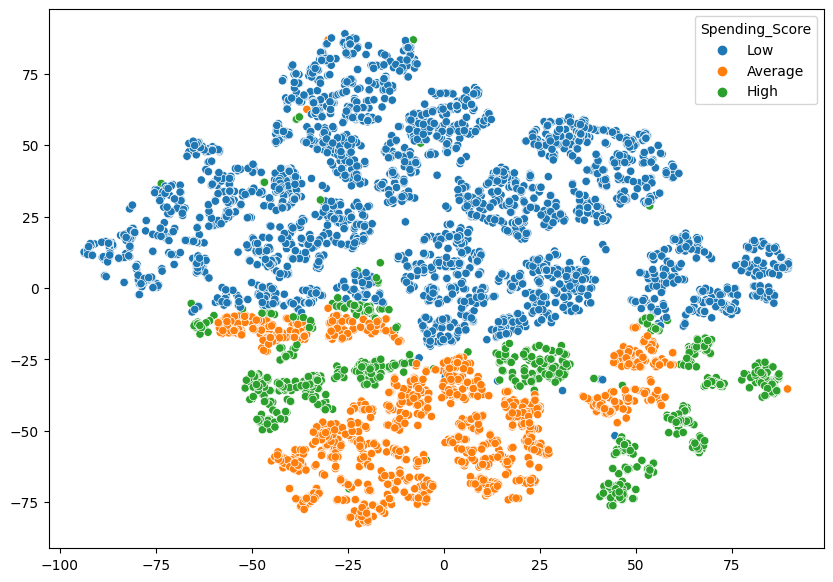

In [53]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data2d[:, 0], y = data2d[:, 1], hue=train_df['Spending_Score'], cmap='tab10')

In [54]:
model = DBSCAN(eps=0.3, min_samples=5)
db = model.fit(X)
labels = db.labels_
uniq_labels = set(labels)

In [55]:
np.unique(labels, return_counts=True)

(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
         25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
         51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165]),
 array([5597,   20,   57,    5,   30,   16,   38,    5,   3

<Axes: >

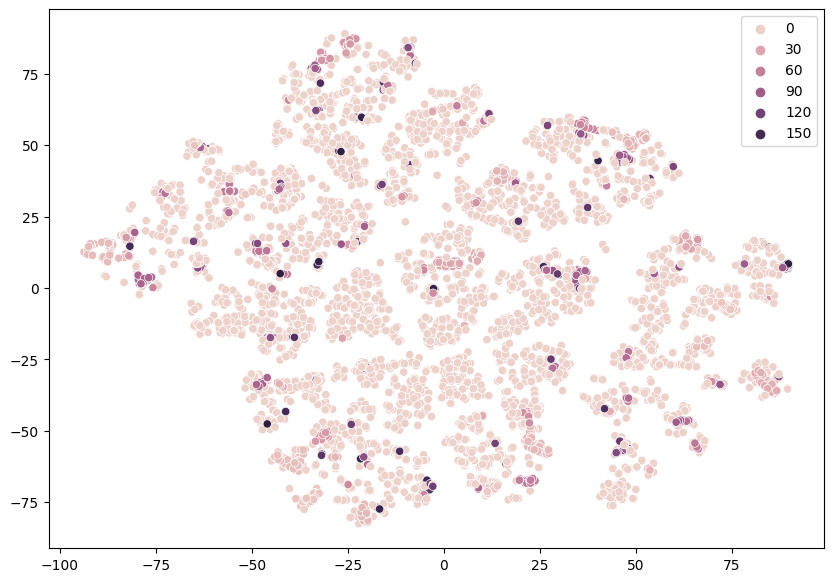

In [56]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data2d[:, 0], y = data2d[:, 1], hue=labels)

In [57]:
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans

In [58]:
n_cluster = 6
Agg_hc = AgglomerativeClustering(n_clusters = n_cluster, affinity = 'euclidean', linkage = 'ward')
y_hc = Agg_hc.fit_predict(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


<Axes: >

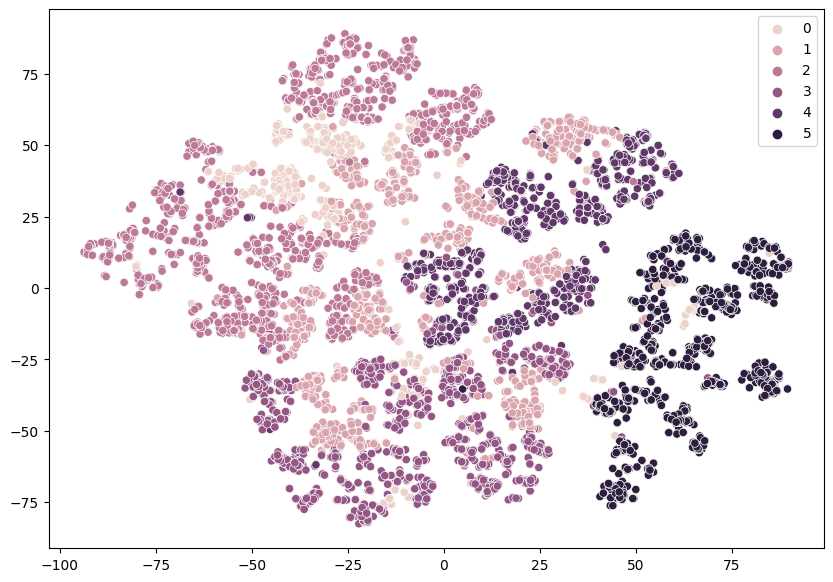

In [59]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data2d[:, 0], y = data2d[:, 1], hue=y_hc)

In [60]:
n_clusters = 4
clusterer = KMeans(n_clusters=n_clusters, random_state=16, max_iter=2500)
y = clusterer.fit_predict(X)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: >

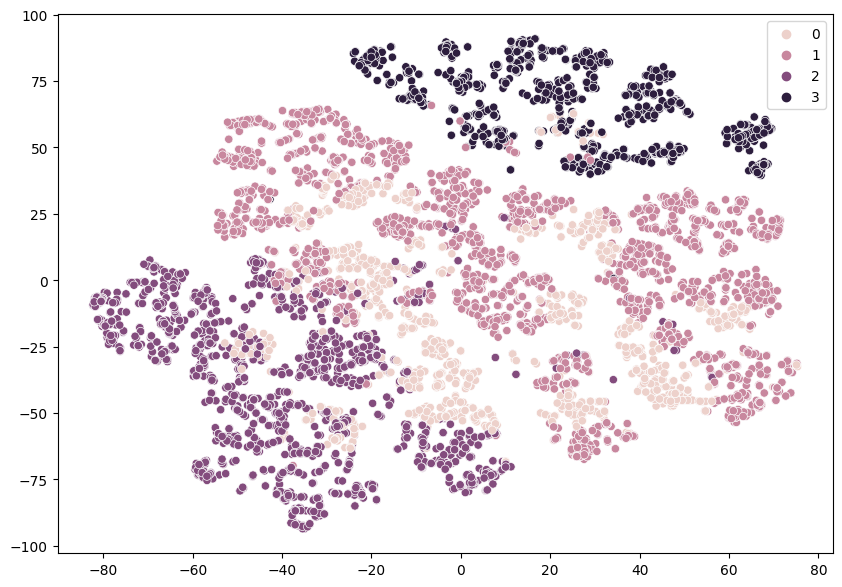

In [30]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=data2d[:, 0], y = data2d[:, 1], hue=y)

For n_clusters = 4 The average silhouette_score is : 0.16962672646372215
For n_clusters = 5 The average silhouette_score is : 0.13625311061876524
For n_clusters = 6 The average silhouette_score is : 0.11696280079467174
For n_clusters = 7 The average silhouette_score is : 0.09944593700807663


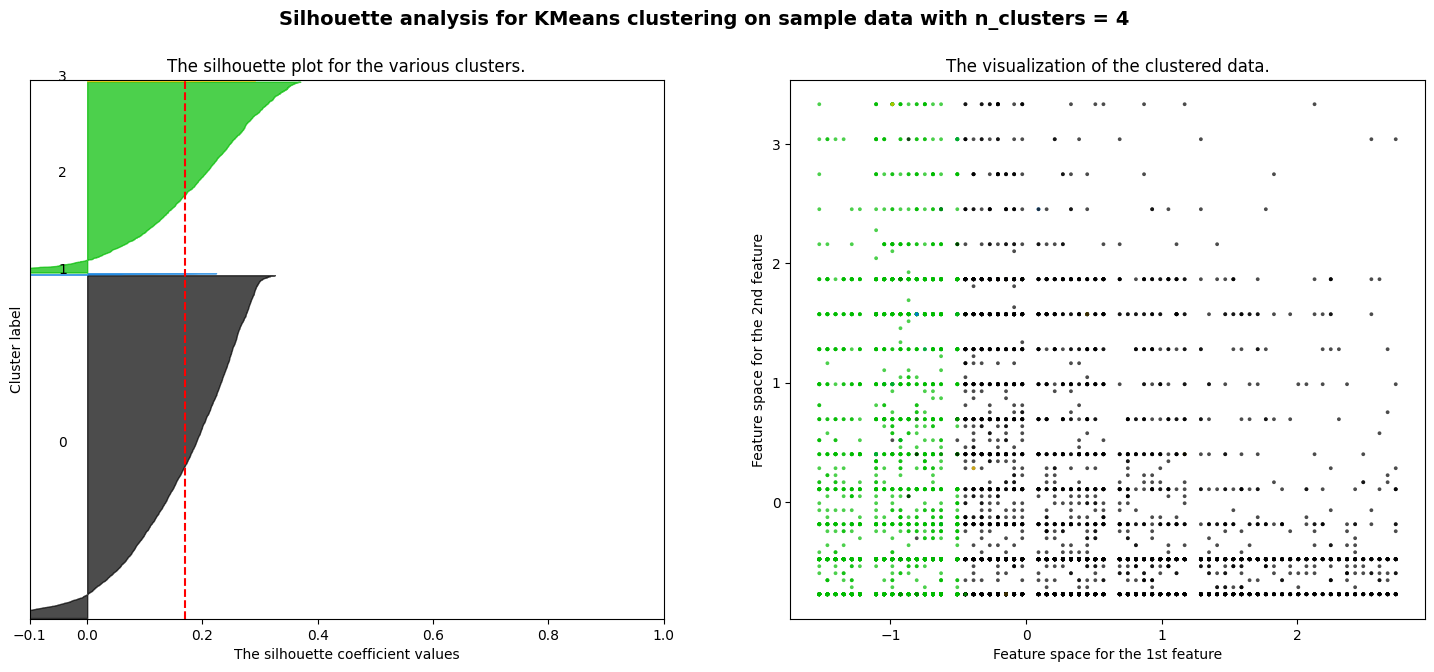

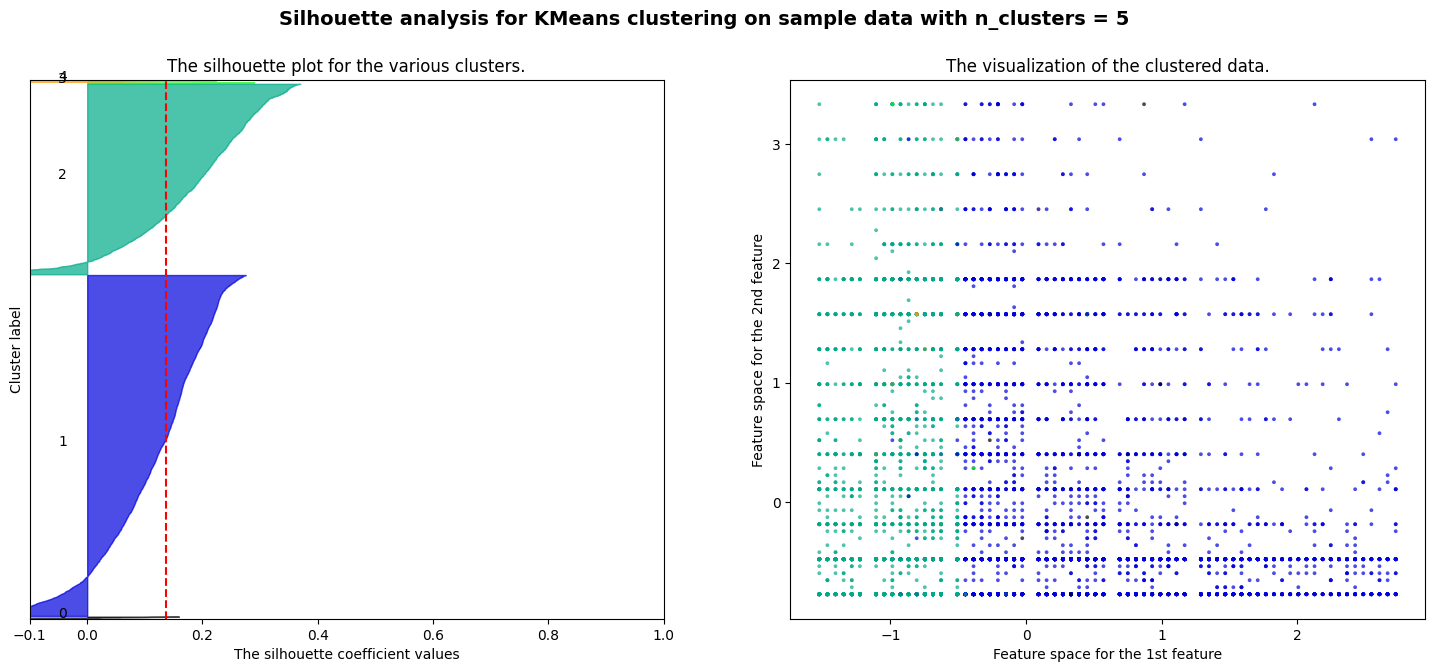

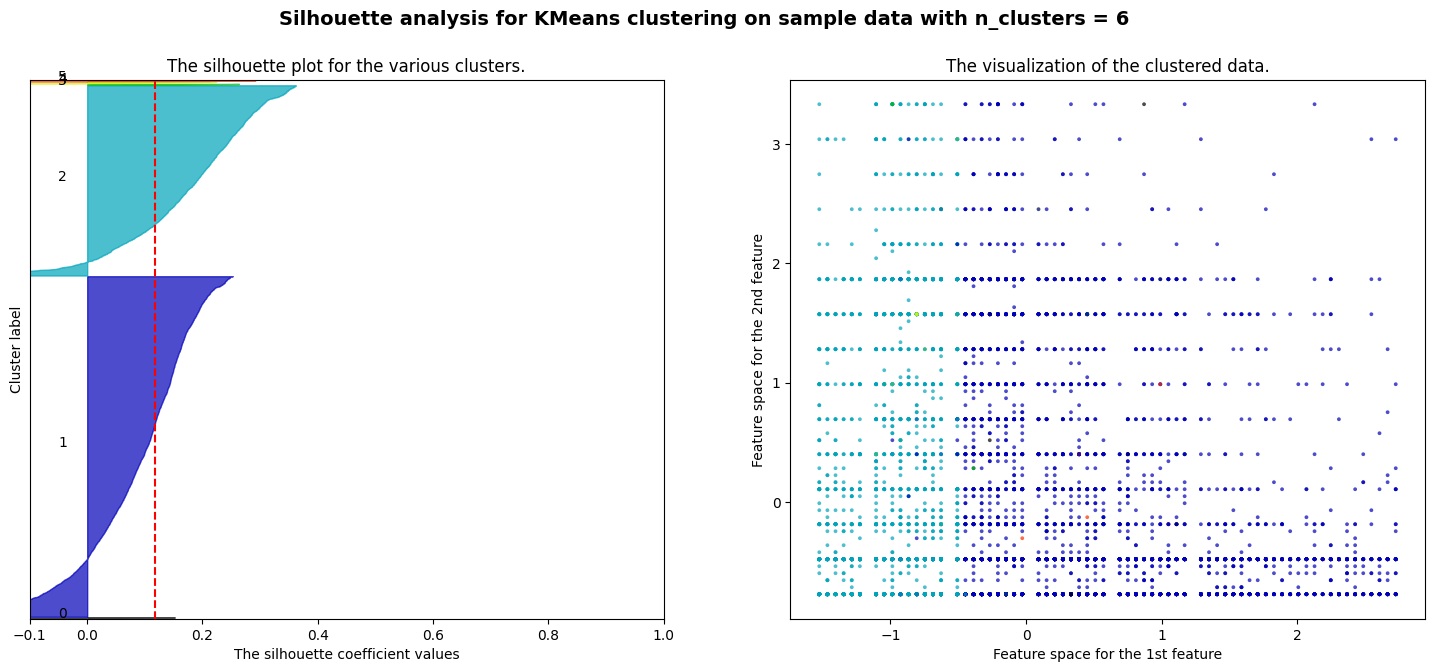

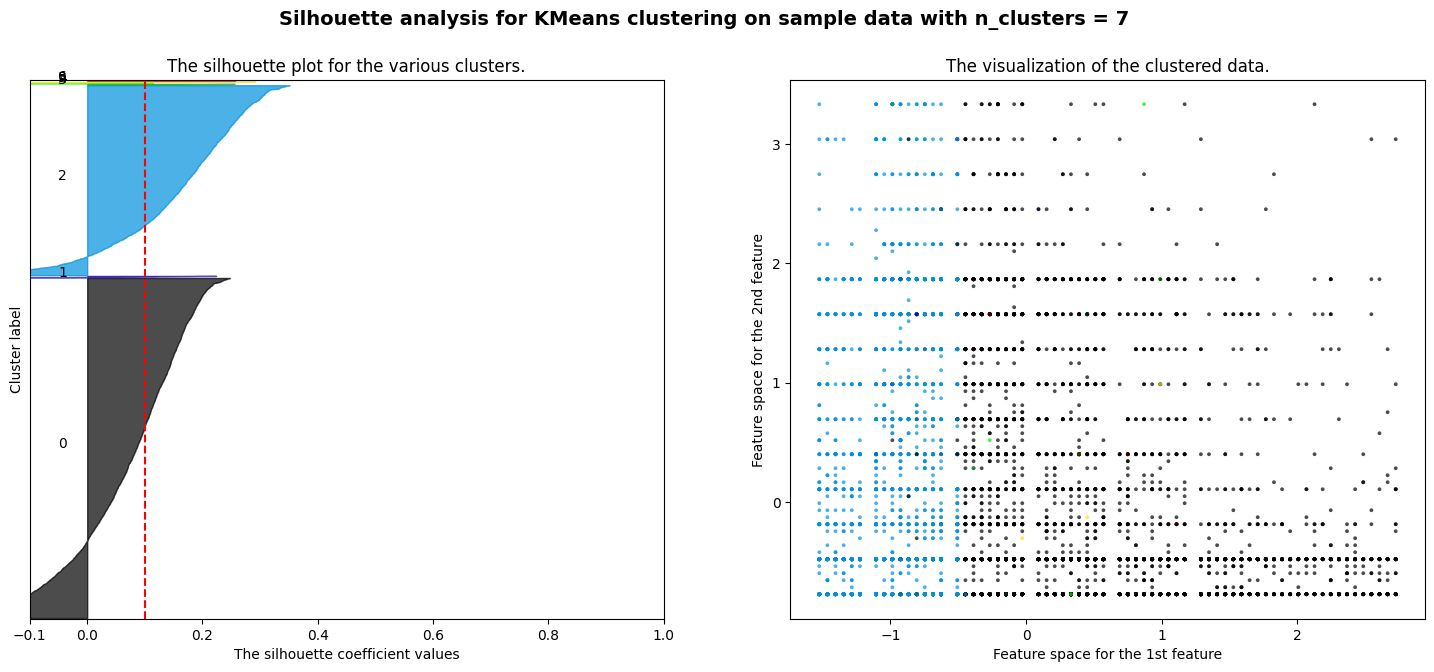

In [61]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

for n_clusters in range(4,8,1):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = AgglomerativeClustering(n_clusters = n_clusters, metric = 'manhattan', linkage = 'average')
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

#     # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [32]:
subm_df = pd.DataFrame({'ID': train_df.ID, 'Segmentation': y})

In [33]:
labelencoder = dict()
i = 1
for x in subm_df['Segmentation']:
  if x not in labelencoder:
    labelencoder[x] = i
    i += 1

In [34]:
labelencoder

{2: 1, 1: 2, 3: 3, 0: 4}

In [35]:
subm_df['Segmentation'] = subm_df['Segmentation'].apply(lambda x: labelencoder[x])

In [36]:
subm_df

,ID,Segmentation
0,462809,1
1,462643,2
2,466315,3
3,461735,3
4,462669,2
...,...,...
8063,464018,1
8064,464685,1
8065,465406,1
8066,467299,1


In [37]:
subm_df.to_csv('subm.csv', index=False)